<a href="https://colab.research.google.com/github/gamecicn/ECE661_FinalProject/blob/main/notebooks/question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
# set working dictionary
import os
import sys
from google.colab import drive

drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive/ECE661/FinalProject')
sys.path.append('/content/drive/MyDrive/ECE661/FinalProject')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime 
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# parameters
RANDOM_SEED = 42

IMG_SIZE = 28
N_CLASSES = 10

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {DEVICE}")

#############################################
# your code here
# construct dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                 transform=torchvision.transforms.Compose([
                      torchvision.transforms.ToTensor()
                 ])),
  batch_size=VAL_BATCH_SIZE, shuffle=True)

Device: cuda


## Check Images

In [97]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1, train_fun = train):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train_fun(train_loader, model, train_criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, valid_criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

## Models

In [121]:

class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

class StudentNet(nn.Module):

    def __init__(self, n_classes):
        super(StudentNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Conv2d(1, 1, 5, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(1, 2, 5, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(32, 10),
        )
 

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


## Train Teacher Model

In [107]:
import os.path

LeNet5_CHECKPOINT = "LeNet5_trained_parameters.pt"
torch.manual_seed(RANDOM_SEED)

model_teacher = LeNet5(N_CLASSES).to(DEVICE)

if os.path.exists(LeNet5_CHECKPOINT):

  # load model Directly
  print("==========> Load Parameters")
  model_teacher.load_state_dict(torch.load(LeNet5_CHECKPOINT))
  
else:

  # If model not trained 
  print("==========> Not find checkpoint, train")

  LEARNING_RATE = 0.001
  N_EPOCHS = 15
  optimizer = torch.optim.Adam(model_teacher.parameters(), lr=LEARNING_RATE)
  train_criterion = nn.CrossEntropyLoss()
  valid_criterion = nn.CrossEntropyLoss()

  model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

  # Save model 
  torch.save(model_teacher.state_dict(), LeNet5_CHECKPOINT)
  


==========> Load Parameters


# Train student model base on teacher's soft label

## Small Model : *Student Model*

# Different Temprature 

=======> Temperature: 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


03:58:11 --- Epoch: 0	Train loss: 0.0000	Valid loss: 2.3019	Train accuracy: 27.66	Valid accuracy: 27.94
03:58:22 --- Epoch: 1	Train loss: 0.0000	Valid loss: 2.3013	Train accuracy: 33.58	Valid accuracy: 33.98
03:58:34 --- Epoch: 2	Train loss: 0.0000	Valid loss: 2.2988	Train accuracy: 64.32	Valid accuracy: 65.50
03:58:46 --- Epoch: 3	Train loss: 0.0000	Valid loss: 2.2976	Train accuracy: 69.82	Valid accuracy: 71.14
03:58:58 --- Epoch: 4	Train loss: 0.0000	Valid loss: 2.2973	Train accuracy: 72.74	Valid accuracy: 73.64
03:59:10 --- Epoch: 5	Train loss: 0.0000	Valid loss: 2.2967	Train accuracy: 78.82	Valid accuracy: 79.62
03:59:22 --- Epoch: 6	Train loss: 0.0000	Valid loss: 2.2959	Train accuracy: 74.86	Valid accuracy: 75.96
03:59:34 --- Epoch: 7	Train loss: 0.0000	Valid loss: 2.2951	Train accuracy: 80.86	Valid accuracy: 81.38
03:59:46 --- Epoch: 8	Train loss: 0.0000	Valid loss: 2.2941	Train accuracy: 82.09	Valid accuracy: 83.24
03:59:58 --- Epoch: 9	Train loss: 0.0000	Valid loss: 2.2943	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:01:09 --- Epoch: 0	Train loss: 0.0000	Valid loss: 2.2702	Train accuracy: 79.97	Valid accuracy: 81.35
04:01:20 --- Epoch: 1	Train loss: 0.0000	Valid loss: 2.2655	Train accuracy: 84.25	Valid accuracy: 85.30
04:01:32 --- Epoch: 2	Train loss: 0.0000	Valid loss: 2.2633	Train accuracy: 86.36	Valid accuracy: 87.00
04:01:44 --- Epoch: 3	Train loss: 0.0000	Valid loss: 2.2604	Train accuracy: 87.69	Valid accuracy: 88.22
04:01:56 --- Epoch: 4	Train loss: 0.0000	Valid loss: 2.2583	Train accuracy: 87.40	Valid accuracy: 87.99
04:02:08 --- Epoch: 5	Train loss: 0.0000	Valid loss: 2.2591	Train accuracy: 88.80	Valid accuracy: 89.03
04:02:20 --- Epoch: 6	Train loss: 0.0000	Valid loss: 2.2590	Train accuracy: 87.44	Valid accuracy: 87.78
04:02:31 --- Epoch: 7	Train loss: 0.0000	Valid loss: 2.2575	Train accuracy: 88.81	Valid accuracy: 89.04
04:02:43 --- Epoch: 8	Train loss: 0.0000	Valid loss: 2.2573	Train accuracy: 89.65	Valid accuracy: 90.03
04:02:55 --- Epoch: 9	Train loss: 0.0000	Valid loss: 2.2592	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:04:06 --- Epoch: 0	Train loss: 0.0000	Valid loss: 2.2580	Train accuracy: 70.38	Valid accuracy: 70.23
04:04:18 --- Epoch: 1	Train loss: 0.0000	Valid loss: 2.2381	Train accuracy: 82.75	Valid accuracy: 83.84
04:04:30 --- Epoch: 2	Train loss: 0.0000	Valid loss: 2.2323	Train accuracy: 83.73	Valid accuracy: 84.58
04:04:41 --- Epoch: 3	Train loss: 0.0000	Valid loss: 2.2350	Train accuracy: 85.60	Valid accuracy: 86.28
04:04:53 --- Epoch: 4	Train loss: 0.0000	Valid loss: 2.2330	Train accuracy: 85.80	Valid accuracy: 86.18
04:05:04 --- Epoch: 5	Train loss: 0.0000	Valid loss: 2.2290	Train accuracy: 86.21	Valid accuracy: 86.77
04:05:16 --- Epoch: 6	Train loss: 0.0000	Valid loss: 2.2313	Train accuracy: 86.41	Valid accuracy: 86.72
04:05:27 --- Epoch: 7	Train loss: 0.0000	Valid loss: 2.2281	Train accuracy: 86.68	Valid accuracy: 86.90
04:05:39 --- Epoch: 8	Train loss: 0.0000	Valid loss: 2.2275	Train accuracy: 86.77	Valid accuracy: 87.16
04:05:51 --- Epoch: 9	Train loss: 0.0000	Valid loss: 2.2259	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:07:01 --- Epoch: 0	Train loss: 0.0002	Valid loss: 1.9624	Train accuracy: 85.31	Valid accuracy: 85.43
04:07:12 --- Epoch: 1	Train loss: 0.0001	Valid loss: 1.9214	Train accuracy: 87.99	Valid accuracy: 88.26
04:07:24 --- Epoch: 2	Train loss: 0.0001	Valid loss: 1.9040	Train accuracy: 89.51	Valid accuracy: 90.02
04:07:35 --- Epoch: 3	Train loss: 0.0001	Valid loss: 1.8997	Train accuracy: 90.53	Valid accuracy: 90.78
04:07:47 --- Epoch: 4	Train loss: 0.0001	Valid loss: 1.8675	Train accuracy: 91.48	Valid accuracy: 91.78
04:07:59 --- Epoch: 5	Train loss: 0.0001	Valid loss: 1.8680	Train accuracy: 91.97	Valid accuracy: 92.49
04:08:10 --- Epoch: 6	Train loss: 0.0001	Valid loss: 1.8464	Train accuracy: 92.85	Valid accuracy: 93.15
04:08:21 --- Epoch: 7	Train loss: 0.0001	Valid loss: 1.8404	Train accuracy: 93.32	Valid accuracy: 93.61
04:08:33 --- Epoch: 8	Train loss: 0.0001	Valid loss: 1.8300	Train accuracy: 93.56	Valid accuracy: 93.95
04:08:44 --- Epoch: 9	Train loss: 0.0001	Valid loss: 1.8206	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:09:53 --- Epoch: 0	Train loss: 0.0012	Valid loss: 1.7447	Train accuracy: 84.42	Valid accuracy: 84.66
04:10:05 --- Epoch: 1	Train loss: 0.0004	Valid loss: 1.6524	Train accuracy: 87.97	Valid accuracy: 88.06
04:10:17 --- Epoch: 2	Train loss: 0.0004	Valid loss: 1.6126	Train accuracy: 89.35	Valid accuracy: 89.56
04:10:29 --- Epoch: 3	Train loss: 0.0003	Valid loss: 1.5899	Train accuracy: 90.40	Valid accuracy: 90.78
04:10:40 --- Epoch: 4	Train loss: 0.0003	Valid loss: 1.5659	Train accuracy: 91.32	Valid accuracy: 91.75
04:10:52 --- Epoch: 5	Train loss: 0.0003	Valid loss: 1.5442	Train accuracy: 92.09	Valid accuracy: 92.38
04:11:04 --- Epoch: 6	Train loss: 0.0002	Valid loss: 1.5268	Train accuracy: 92.80	Valid accuracy: 93.18
04:11:15 --- Epoch: 7	Train loss: 0.0002	Valid loss: 1.4944	Train accuracy: 93.38	Valid accuracy: 93.76
04:11:27 --- Epoch: 8	Train loss: 0.0002	Valid loss: 1.4671	Train accuracy: 93.72	Valid accuracy: 94.19
04:11:39 --- Epoch: 9	Train loss: 0.0002	Valid loss: 1.4564	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:12:48 --- Epoch: 0	Train loss: 0.0092	Valid loss: 2.3022	Train accuracy: 11.24	Valid accuracy: 11.35
04:12:59 --- Epoch: 1	Train loss: 0.0092	Valid loss: 2.3021	Train accuracy: 11.24	Valid accuracy: 11.35
04:13:11 --- Epoch: 2	Train loss: 0.0092	Valid loss: 2.3021	Train accuracy: 11.24	Valid accuracy: 11.35
04:13:23 --- Epoch: 3	Train loss: 0.0092	Valid loss: 2.3021	Train accuracy: 11.24	Valid accuracy: 11.35
04:13:34 --- Epoch: 4	Train loss: 0.0092	Valid loss: 2.3020	Train accuracy: 11.24	Valid accuracy: 11.35
04:13:46 --- Epoch: 5	Train loss: 0.0092	Valid loss: 2.3020	Train accuracy: 11.24	Valid accuracy: 11.35
04:13:57 --- Epoch: 6	Train loss: 0.0092	Valid loss: 2.3019	Train accuracy: 11.24	Valid accuracy: 11.35
04:14:09 --- Epoch: 7	Train loss: 0.0092	Valid loss: 2.3021	Train accuracy: 11.24	Valid accuracy: 11.35
04:14:20 --- Epoch: 8	Train loss: 0.0092	Valid loss: 2.3020	Train accuracy: 11.24	Valid accuracy: 11.35
04:14:32 --- Epoch: 9	Train loss: 0.0092	Valid loss: 2.3020	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:15:41 --- Epoch: 0	Train loss: 0.0346	Valid loss: 0.8627	Train accuracy: 80.41	Valid accuracy: 82.06
04:15:53 --- Epoch: 1	Train loss: 0.0133	Valid loss: 0.6595	Train accuracy: 86.22	Valid accuracy: 86.95
04:16:05 --- Epoch: 2	Train loss: 0.0102	Valid loss: 0.5451	Train accuracy: 88.85	Valid accuracy: 89.41
04:16:16 --- Epoch: 3	Train loss: 0.0085	Valid loss: 0.4806	Train accuracy: 90.49	Valid accuracy: 90.83
04:16:28 --- Epoch: 4	Train loss: 0.0074	Valid loss: 0.4316	Train accuracy: 91.51	Valid accuracy: 91.87
04:16:40 --- Epoch: 5	Train loss: 0.0066	Valid loss: 0.3962	Train accuracy: 92.11	Valid accuracy: 92.57
04:16:51 --- Epoch: 6	Train loss: 0.0062	Valid loss: 0.3696	Train accuracy: 92.67	Valid accuracy: 93.08
04:17:03 --- Epoch: 7	Train loss: 0.0058	Valid loss: 0.3489	Train accuracy: 92.86	Valid accuracy: 93.46
04:17:14 --- Epoch: 8	Train loss: 0.0056	Valid loss: 0.3303	Train accuracy: 93.13	Valid accuracy: 93.75
04:17:26 --- Epoch: 9	Train loss: 0.0054	Valid loss: 0.3213	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:18:35 --- Epoch: 0	Train loss: 0.2284	Valid loss: 2.3011	Train accuracy: 11.24	Valid accuracy: 11.35
04:18:47 --- Epoch: 1	Train loss: 0.2284	Valid loss: 2.3009	Train accuracy: 11.24	Valid accuracy: 11.35
04:18:58 --- Epoch: 2	Train loss: 0.0942	Valid loss: 0.4899	Train accuracy: 84.30	Valid accuracy: 84.85
04:19:10 --- Epoch: 3	Train loss: 0.0451	Valid loss: 0.4148	Train accuracy: 86.64	Valid accuracy: 87.18
04:19:21 --- Epoch: 4	Train loss: 0.0405	Valid loss: 0.3825	Train accuracy: 87.80	Valid accuracy: 88.00
04:19:33 --- Epoch: 5	Train loss: 0.0381	Valid loss: 0.3736	Train accuracy: 88.10	Valid accuracy: 88.45
04:19:45 --- Epoch: 6	Train loss: 0.0366	Valid loss: 0.3565	Train accuracy: 88.67	Valid accuracy: 89.09
04:19:56 --- Epoch: 7	Train loss: 0.0354	Valid loss: 0.3445	Train accuracy: 89.12	Valid accuracy: 89.46
04:20:08 --- Epoch: 8	Train loss: 0.0344	Valid loss: 0.3358	Train accuracy: 89.29	Valid accuracy: 89.90
04:20:19 --- Epoch: 9	Train loss: 0.0336	Valid loss: 0.3320	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:21:29 --- Epoch: 0	Train loss: 0.4318	Valid loss: 0.5700	Train accuracy: 84.83	Valid accuracy: 85.82
04:21:40 --- Epoch: 1	Train loss: 0.1649	Valid loss: 0.4736	Train accuracy: 87.88	Valid accuracy: 88.80
04:21:52 --- Epoch: 2	Train loss: 0.1416	Valid loss: 0.4378	Train accuracy: 88.92	Valid accuracy: 89.67
04:22:04 --- Epoch: 3	Train loss: 0.1312	Valid loss: 0.4127	Train accuracy: 89.54	Valid accuracy: 90.09
04:22:15 --- Epoch: 4	Train loss: 0.1246	Valid loss: 0.4013	Train accuracy: 89.92	Valid accuracy: 90.28
04:22:27 --- Epoch: 5	Train loss: 0.1198	Valid loss: 0.3868	Train accuracy: 90.33	Valid accuracy: 90.75
04:22:39 --- Epoch: 6	Train loss: 0.1163	Valid loss: 0.3719	Train accuracy: 90.44	Valid accuracy: 91.08
04:22:50 --- Epoch: 7	Train loss: 0.1132	Valid loss: 0.3679	Train accuracy: 90.38	Valid accuracy: 90.67
04:23:02 --- Epoch: 8	Train loss: 0.1112	Valid loss: 0.3584	Train accuracy: 90.76	Valid accuracy: 91.26
04:23:13 --- Epoch: 9	Train loss: 0.1089	Valid loss: 0.3478	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:24:24 --- Epoch: 0	Train loss: 1.8114	Valid loss: 0.8594	Train accuracy: 79.60	Valid accuracy: 80.81
04:24:35 --- Epoch: 1	Train loss: 0.8484	Valid loss: 0.6734	Train accuracy: 84.33	Valid accuracy: 85.32
04:24:47 --- Epoch: 2	Train loss: 0.7312	Valid loss: 0.5874	Train accuracy: 86.19	Valid accuracy: 86.83
04:24:58 --- Epoch: 3	Train loss: 0.6495	Valid loss: 0.4799	Train accuracy: 88.33	Valid accuracy: 89.07
04:25:10 --- Epoch: 4	Train loss: 0.5791	Valid loss: 0.4288	Train accuracy: 89.41	Valid accuracy: 90.01
04:25:22 --- Epoch: 5	Train loss: 0.5262	Valid loss: 0.3845	Train accuracy: 90.18	Valid accuracy: 90.89
04:25:34 --- Epoch: 6	Train loss: 0.4896	Valid loss: 0.3638	Train accuracy: 90.58	Valid accuracy: 91.17
04:25:45 --- Epoch: 7	Train loss: 0.4633	Valid loss: 0.3438	Train accuracy: 90.84	Valid accuracy: 91.64
04:25:57 --- Epoch: 8	Train loss: 0.4443	Valid loss: 0.3176	Train accuracy: 91.40	Valid accuracy: 92.14
04:26:09 --- Epoch: 9	Train loss: 0.4287	Valid loss: 0.3016	Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


04:27:20 --- Epoch: 0	Train loss: 2.5013	Valid loss: 1.0867	Train accuracy: 75.74	Valid accuracy: 76.62
04:27:32 --- Epoch: 1	Train loss: 1.2612	Valid loss: 0.8235	Train accuracy: 80.42	Valid accuracy: 81.34
04:27:44 --- Epoch: 2	Train loss: 1.0598	Valid loss: 0.6521	Train accuracy: 83.64	Valid accuracy: 84.71
04:27:55 --- Epoch: 3	Train loss: 0.9498	Valid loss: 0.5706	Train accuracy: 85.42	Valid accuracy: 86.24
04:28:07 --- Epoch: 4	Train loss: 0.8832	Valid loss: 0.5112	Train accuracy: 86.59	Valid accuracy: 87.24
04:28:19 --- Epoch: 5	Train loss: 0.8398	Valid loss: 0.4576	Train accuracy: 87.76	Valid accuracy: 88.66
04:28:31 --- Epoch: 6	Train loss: 0.8090	Valid loss: 0.4431	Train accuracy: 87.97	Valid accuracy: 88.81
04:28:42 --- Epoch: 7	Train loss: 0.7856	Valid loss: 0.4483	Train accuracy: 87.80	Valid accuracy: 88.31
04:28:54 --- Epoch: 8	Train loss: 0.7673	Valid loss: 0.4006	Train accuracy: 88.94	Valid accuracy: 89.66
04:29:06 --- Epoch: 9	Train loss: 0.7528	Valid loss: 0.3988	Trai

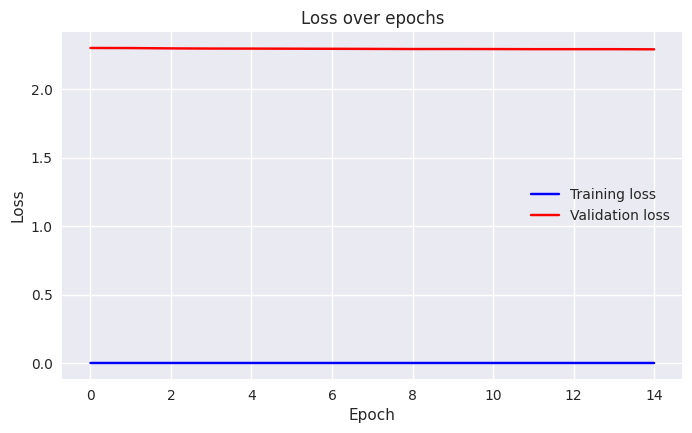

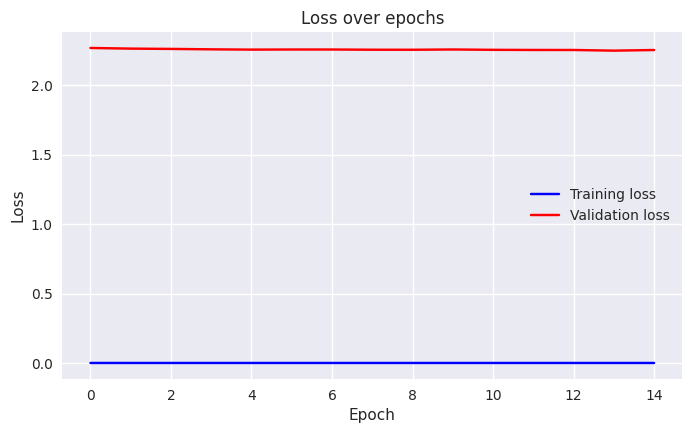

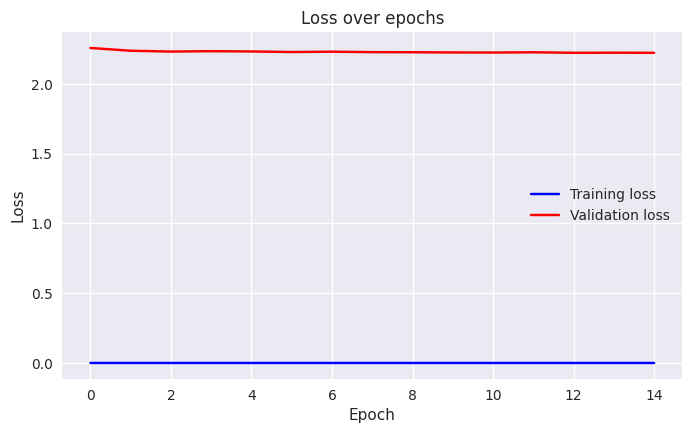

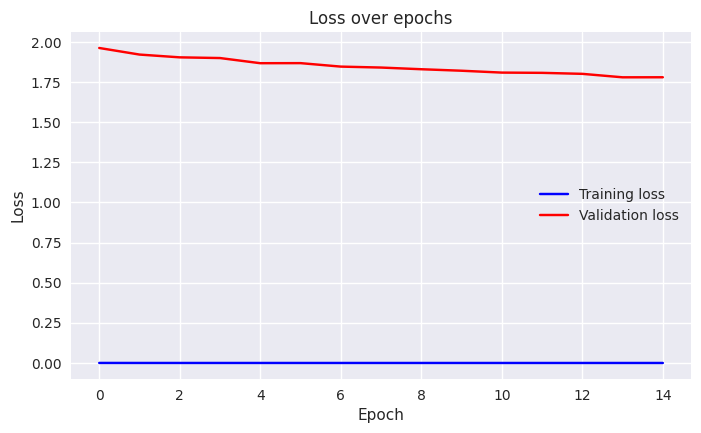

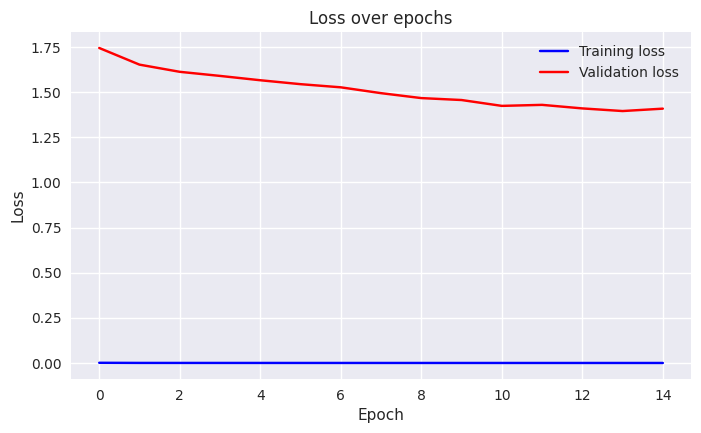

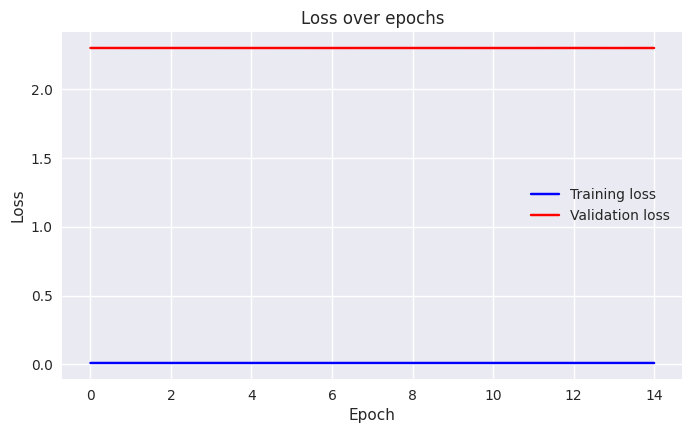

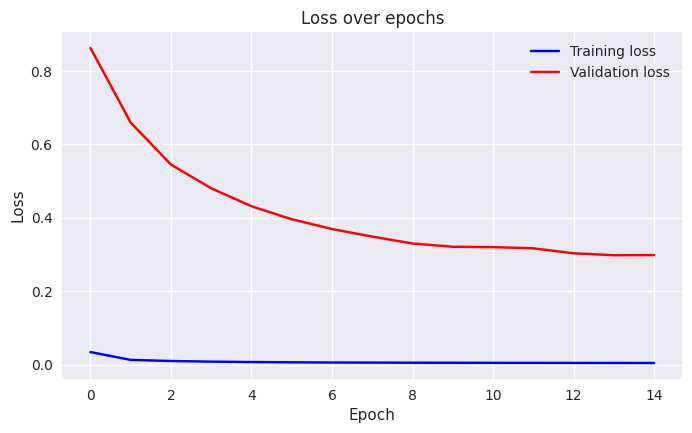

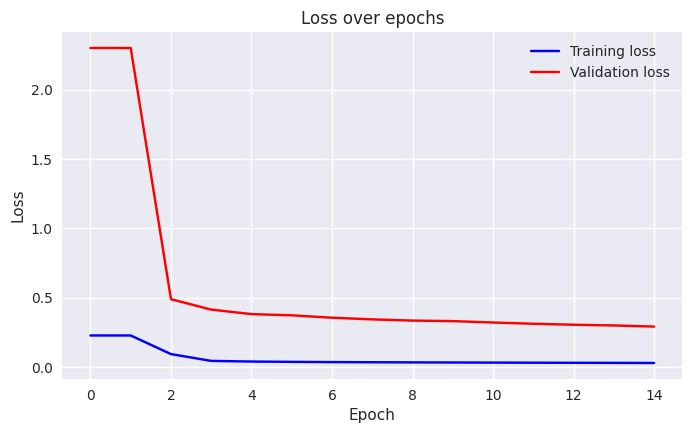

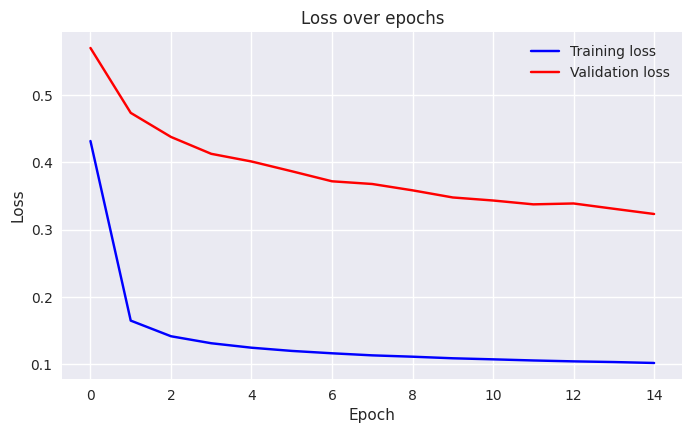

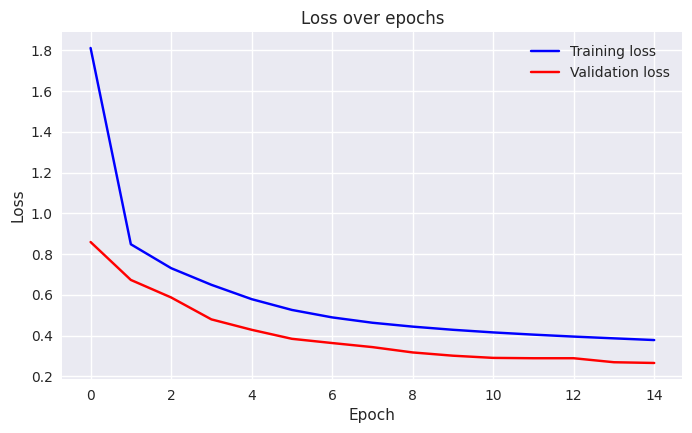

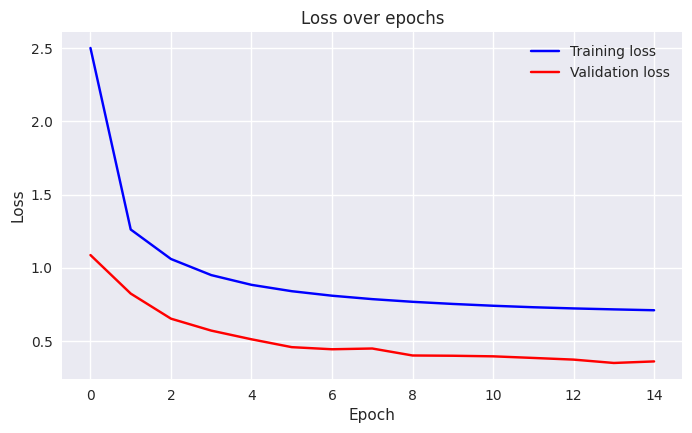

In [125]:
class SoftCrossEntropyLoss():

  def __init__(self, temperature):
    self.T = temperature

  def loss(self, student_pred, teacher_pred):
    return nn.KLDivLoss()(F.log_softmax(student_pred/self.T), F.softmax(teacher_pred[0]/self.T)) * self.T * self.T


T = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]

# Train 
LEARNING_RATE = 0.001
N_EPOCHS = 15

for t in T:

  print(f"=======> Temperature: {t}")
  model_s = StudentNet(N_CLASSES).to(DEVICE)
  optimizer = torch.optim.Adam(model_s.parameters(), lr=LEARNING_RATE)

  valid_criterion = nn.CrossEntropyLoss()
  train_criterion = SoftCrossEntropyLoss(t)

  model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE, train_fun=train_soft)

In [112]:
!pip install pthflops
!pip install torchsummary

In [122]:
from pthflops import count_ops
from torchsummary import summary

student_model = StudentNet(N_CLASSES).to(DEVICE)
 
summary(student_model, (1, 28, 28))
count_ops(student_model.model, torch.rand(1,1,28,28).to(DEVICE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              26
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
            Conv2d-4              [-1, 2, 9, 9]              52
              ReLU-5              [-1, 2, 9, 9]               0
         AvgPool2d-6              [-1, 2, 4, 4]               0
           Flatten-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 408
Trainable params: 408
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
OperationOPS     
---  ------  
_0   17576   
_1  

(24598,
 [['_0', 17576],
  ['_1', 1352],
  ['_2', 676],
  ['_3', 4212],
  ['_4', 324],
  ['_5', 128],
  ['_7', 330]])